In [ ]:
# %%
# =========================
# Import Necessary Libraries
# =========================
from utils.utils import CaptionGenerator
from utils.dataset import get_dataset
import pprint
from tqdm import tqdm
import os
import glob
from PIL import Image
import torch
from transformers import CLIPModel, CLIPTokenizer, CLIPFeatureExtractor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import spearmanr
from collections import defaultdict
import torch.nn.functional as F

In [ ]:
# =========================
# Configuration Parameters
# =========================
# available_datasets = ['CUB_200_2011', 'Stanford_dogs', 'Flower102', 'NWPU-RESISC45]
PSEUDO_DATA = False
DATASET_NAME = 'CUB_200_2011'
# MODEL_NAME = "openai/clip-vit-base-patch32"
MODEL_NAME = "openai/clip-vit-large-patch14"
# MODEL_NAME = "google/siglip-base-patch16-224"
# MODEL_NAME = "facebook/flava-full"
PSEUDO_IMAGES_FOLDER = f'pseudo_images/{DATASET_NAME}'
BATCH_SIZE = 64         # Adjust based on your GPU memory
KNN_BATCH_SIZE = 1024   # For zero-shot accuracy computation
NUM_CAPTIONS = 32       # Number of alternative captions per class
TSNE_PERPLEXITY = 30    # Perplexity parameter for t-SNE
TSNE_N_ITER = 1000      # Number of iterations for t-SNE
TOP_K_CLASSES = 12      # Number of classes to visualize in t-SNE

In [ ]:
# =========================
# Load and Prepare Dataset
# =========================


cub_dataset = get_dataset(DATASET_NAME) 
n_object = len(cub_dataset.classes)
print(f"n object: {n_object}")
n_classes = cub_dataset.classes[:n_object]
pprint.pprint(n_classes)
# Update class_to_idx mapping for quick lookup
cub_dataset.class_to_idx = {class_name: idx for idx, class_name in enumerate(cub_dataset.classes)}


n object: 200
['Black footed Albatross',
 'Laysan Albatross',
 'Sooty Albatross',
 'Groove billed Ani',
 'Crested Auklet',
 'Least Auklet',
 'Parakeet Auklet',
 'Rhinoceros Auklet',
 'Brewer Blackbird',
 'Red winged Blackbird',
 'Rusty Blackbird',
 'Yellow headed Blackbird',
 'Bobolink',
 'Indigo Bunting',
 'Lazuli Bunting',
 'Painted Bunting',
 'Cardinal',
 'Spotted Catbird',
 'Gray Catbird',
 'Yellow breasted Chat',
 'Eastern Towhee',
 'Chuck will Widow',
 'Brandt Cormorant',
 'Red faced Cormorant',
 'Pelagic Cormorant',
 'Bronzed Cowbird',
 'Shiny Cowbird',
 'Brown Creeper',
 'American Crow',
 'Fish Crow',
 'Black billed Cuckoo',
 'Mangrove Cuckoo',
 'Yellow billed Cuckoo',
 'Gray crowned Rosy Finch',
 'Purple Finch',
 'Northern Flicker',
 'Acadian Flycatcher',
 'Great Crested Flycatcher',
 'Least Flycatcher',
 'Olive sided Flycatcher',
 'Scissor tailed Flycatcher',
 'Vermilion Flycatcher',
 'Yellow bellied Flycatcher',
 'Frigatebird',
 'Northern Fulmar',
 'Gadwall',
 'American Gold

In [ ]:
# %%
# =========================
# Generate Prompts and Captions
# =========================

# Generate standard prompts
standard_prompts = [f"a photo of a {class_name}" for class_name in n_classes]

# if DATASET_NAME == 'NWPU-RESISC45':
#     # for NWPU-RESISC45 dataset, we should mention satellite image
#     standard_prompts = [f"a satellite image of a {class_name}" for class_name in n_classes]
standard_labels = n_classes  # Labels for standard prompts

# Initialize CaptionGenerator and generate alternative captions
capGenerator = CaptionGenerator(dataset_name=DATASET_NAME, class_names=n_classes, num_captions=NUM_CAPTIONS)

alter_caption_list = []
labels = []
for class_name in tqdm(n_classes, desc="Generating Alternative Captions"):
    alter_captions = capGenerator.get_alternative_captions(class_name)
    alter_caption_list.extend(alter_captions)
    labels.extend([class_name] * len(alter_captions))


Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011_global_traits.json
Using OpenAI model: gpt-4o-mini-2024-07-18
Configured to generate 12 captions.
Meta Prompt: You are an AI assistant that generates creative and diverse image captions suitable for use with image generation models like DALL-E. Given a subject, provide 12 distinct, diverse and descriptive captions, considering the following global taxonomical traits when generating captions: ['Feeding behavior (e.g., piscivorous, frugivorous, granivorous)', 'Habitat preference (e.g., wetlands, forests, grasslands)', 'Body size and shape', 'Coloration patterns (e.g., vibrant colors, camouflage)', 'Wing morphology (e.g., long wings for soaring, short wings for maneuverability)', 'Bill shape and size (e.g., curved, straight, long, short)', 'Nesting habits (e.g., ground-nesting, tree-nesting)', 'Social behavior (e.g., solitary, flocking)', 'Migration patterns (e.g., migratory, sedentary)', 'Vocalization patterns (e.g., song,

Generating Alternative Captions: 100%|██████████| 200/200 [00:00<00:00, 3144.32it/s]

Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Black_footed_Albatross.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Laysan_Albatross.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Sooty_Albatross.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Groove_billed_Ani.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Crested_Auklet.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Least_Auklet.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Parakeet_Auklet.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Rhinoceros_Auklet.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Brewer_Blackbird.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Red_winged_Blackbird.json
Loaded data from cache: cache\gpt-4o-mini-2024-07-18\CUB_200_2011\12\Rusty_Blackbird.j

In [ ]:
# # =========================
# # Initialize CLIP Model and Tokenizers
# # =========================
# tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)
# feature_extractor = CLIPFeatureExtractor.from_pretrained(MODEL_NAME)
# model = CLIPModel.from_pretrained(MODEL_NAME).cuda()
# model.eval()

In [ ]:
# =========================
# Define Helper Functions
# =========================

# def get_text_embeddings(captions, tokenizer, model, device):
#     """
#     Compute normalized text embeddings for a list of captions.

#     Args:
#         captions (List[str]): List of textual captions.
#         tokenizer (CLIPTokenizer): Tokenizer for CLIP.
#         model (CLIPModel): Pretrained CLIP model.
#         device (torch.device): Device to perform computations on.

#     Returns:
#         np.ndarray: Normalized text embeddings.
#     """
#     inputs = tokenizer(captions, padding=True, truncation=True, return_tensors="pt").to(device)
#     with torch.no_grad():
#         embeddings = model.get_text_features(**inputs).detach()
#     embeddings = F.normalize(embeddings, p=2, dim=-1)
#     return embeddings.cpu().numpy()

# def get_image_embeddings(dataloader, model, feature_extractor, device):
#     """
#     Compute normalized image embeddings for a dataset.

#     Args:
#         dataloader (DataLoader): DataLoader for the image dataset.
#         model (CLIPModel): Pretrained CLIP model.
#         feature_extractor (CLIPFeatureExtractor): Feature extractor for images.
#         device (torch.device): Device to perform computations on.

#     Returns:
#         Tuple[np.ndarray, List[str]]: Image embeddings and their corresponding labels.
#     """
#     model.eval()
#     embeddings = []
#     labels = []
#     with torch.no_grad():
#         for batch_images, batch_labels in tqdm(dataloader, desc="Processing Images"):
#             inputs = feature_extractor(images=batch_images, return_tensors="pt").to(device)
#             image_features = model.get_image_features(**inputs).detach()
#             image_features = F.normalize(image_features, p=2, dim=-1)
#             embeddings.append(image_features.cpu().numpy())
#             labels.extend(batch_labels)
#     embeddings = np.concatenate(embeddings, axis=0)
#     return embeddings, labels

from utils.model_utils import get_text_embeddings, get_image_embeddings, load_model

def compute_zero_shot_accuracy(image_embeddings, image_labels, text_embeddings, text_labels, batch_size=1024):
    """
    Compute zero-shot accuracy by matching image embeddings to text embeddings.

    Args:
        image_embeddings (np.ndarray): Image embeddings of shape [num_images, embedding_dim].
        image_labels (List[str]): True labels for each image.
        text_embeddings (np.ndarray): Text embeddings of shape [num_text_embeddings, embedding_dim].
        text_labels (List[str]): Labels corresponding to each text embedding.
        batch_size (int): Batch size for processing.

    Returns:
        Tuple[dict, float, dict, dict]: Per-class accuracy, overall accuracy, class_correct counts, class_total counts.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_features = torch.from_numpy(image_embeddings).to(device)
    text_features = torch.from_numpy(text_embeddings).to(device)

    # Normalize embeddings
    image_features = F.normalize(image_features, p=2, dim=-1)
    text_features = F.normalize(text_features, p=2, dim=-1)

    num_images = image_features.size(0)
    predicted_labels = []

    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for start in tqdm(range(0, num_images, batch_size), desc="Computing Zero-Shot Predictions"):
        end = min(start + batch_size, num_images)
        batch_image = image_features[start:end]  # Shape: [batch_size, embedding_dim]

        # Compute cosine similarity
        similarity = torch.matmul(batch_image, text_features.T)  # Shape: [batch_size, num_text_embeddings]

        # Get indices of most similar text embeddings
        _, max_indices = similarity.max(dim=1)  # Shape: [batch_size]

        # Map indices to labels
        batch_predicted_labels = [text_labels[idx] for idx in max_indices.cpu().numpy()]
        predicted_labels.extend(batch_predicted_labels)

        # Update class_correct and class_total
        for true_label, pred_label in zip(image_labels[start:end], batch_predicted_labels):
            class_total[true_label] += 1
            if true_label == pred_label:
                class_correct[true_label] += 1

    # Compute per-class accuracies
    per_class_accuracy = {}
    for class_name in n_classes:
        if class_total[class_name] > 0:
            accuracy = class_correct[class_name] / class_total[class_name]
            per_class_accuracy[class_name] = accuracy
        else:
            per_class_accuracy[class_name] = None  # No samples for this class

    # Compute overall accuracy
    total_correct = sum(class_correct.values())
    total_samples = sum(class_total.values())
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

    return per_class_accuracy, overall_accuracy, class_correct, class_total




In [ ]:
model_info = load_model(MODEL_NAME)

In [ ]:
# =========================
# Process Pseudo Images (If Enabled)
# =========================
if PSEUDO_DATA:
    # Define custom Dataset for pseudo images
    class PseudoImageDataset(Dataset):
        def __init__(self, image_folder, class_names, transform=None):
            self.image_paths = []
            self.labels = []
            self.transform = transform
            self.class_names = set(class_names)  # For faster lookup

            for image_path in glob.glob(os.path.join(image_folder, '*.png')):
                filename = os.path.basename(image_path)
                class_name = filename.split('-')[0].replace('_', ' ')
                if class_name in self.class_names:
                    self.image_paths.append(image_path)
                    self.labels.append(class_name)

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            label = self.labels[idx]
            image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label

    # Initialize Dataset and DataLoader for pseudo images
    pseudo_dataset = PseudoImageDataset(
        image_folder=PSEUDO_IMAGES_FOLDER,
        class_names=n_classes,
        transform=None  # Add transformations if required
    )

    pseudo_loader = DataLoader(
        pseudo_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        collate_fn=lambda batch: (list(zip(*batch))[0], list(zip(*batch))[1])  # Custom collate function
    )

    # Compute embeddings for pseudo images
    pseudo_embeddings = []
    pseudo_labels = []

    # for batch_images, batch_labels in tqdm(pseudo_loader, desc="Processing Pseudo Images"):
    #     inputs = feature_extractor(images=batch_images, return_tensors="pt").to(model.device)
    #     with torch.no_grad():
    #         image_features = model.get_image_features(**inputs)
    #         image_features = F.normalize(image_features, p=2, dim=-1)
    #     pseudo_embeddings.append(image_features.cpu().numpy())
    #     pseudo_labels.extend(batch_labels)

    # Concatenate embeddings
    # pseudo_embeddings = np.concatenate(pseudo_embeddings, axis=0)
    pseudo_embeddings, pseudo_labels = get_image_embeddings(pseudo_loader, model_info,'cuda')

    # Create pseudo_data entries
    pseudo_data = [
        {'embedding': emb, 'label': label, 'modality': 'pseudo_image'}
        for emb, label in zip(pseudo_embeddings, pseudo_labels)
    ]

In [ ]:
# =========================
# Compute Text Embeddings
# =========================
# Get text embeddings for alternative captions
# text_embeddings = get_text_embeddings(alter_caption_list, tokenizer, model, model.device)
text_embeddings = get_text_embeddings(alter_caption_list, model_info, 'cuda')
text_labels = labels  # Labels for text embeddings

# Create text_data entries
text_data = [
    {'embedding': emb, 'label': label, 'modality': 'text'}
    for emb, label in zip(text_embeddings, text_labels)
]

# Get text embeddings for standard prompts (optional, used for visualization or other purposes)
# standard_embeddings = get_text_embeddings(standard_prompts, tokenizer, model, model.device)
standard_embeddings = get_text_embeddings(standard_prompts, model_info, 'cuda')
standard_data = [
    {'embedding': emb, 'label': label, 'modality': 'standard'}
    for emb, label in zip(standard_embeddings, standard_labels)
]


C:\Users\Wuy19\AppData\Roaming\Python\Python312\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Processed batch 1/38
Processed batch 2/38
Processed batch 3/38
Processed batch 4/38
Processed batch 5/38
Processed batch 6/38
Processed batch 7/38
Processed batch 8/38
Processed batch 9/38
Processed batch 10/38
Processed batch 11/38
Processed batch 12/38
Processed batch 13/38
Processed batch 14/38
Processed batch 15/38
Processed batch 16/38
Processed batch 17/38
Processed batch 18/38
Processed batch 19/38
Processed batch 20/38
Processed batch 21/38
Processed batch 22/38
Processed batch 23/38
Processed batch 24/38
Processed batch 25/38
Processed batch 26/38
Processed batch 27/38
Processed batch 28/38
Processed batch 29/38
Processed batch 30/38
Processed batch 31/38
Processed batch 32/38
Processed batch 33/38
Processed batch 34/38
Processed batch 35/38
Processed batch 36/38
Processed batch 37/38
Processed batch 38/38
Processed batch 1/4
Processed batch 2/4
Processed batch 3/4
Processed batch 4/4


In [ ]:
text_embeddings.shape, standard_embeddings.shape

((2400, 768), (200, 768))

In [ ]:
# =========================
# Compute Image Embeddings for Real Images
# =========================
# Prepare Dataset and DataLoader for real images
# selected_class_indices = [cub_dataset.class_to_idx[class_name] for class_name in n_classes]
# if hasattr(cub_dataset, 'targets'):
#     selected_indices = [i for i, label in enumerate(cub_dataset.targets) if label in selected_class_indices]
# else:
#     selected_indices = [i for i, (_, label) in enumerate(cub_dataset.imgs) if label in selected_class_indices]

# selected_dataset = Subset(cub_dataset, selected_indices)

# image_loader = DataLoader(
#     selected_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     collate_fn=lambda batch: (list(zip(*batch))[0], list(zip(*batch))[1])  # Custom collate function
# )

def get_image_loader(dataset, class_indices, batch_size, shuffle=False):
    if hasattr(dataset, 'targets'):
        selected_indices = [i for i, label in enumerate(dataset.targets) if label in class_indices]
    else:
        selected_indices = [i for i, (_, label) in enumerate(dataset.imgs) if label in class_indices]
    selected_dataset = Subset(dataset, selected_indices)

    transform = None
    selected_dataset.dataset.transform = transform

    loader = DataLoader(
        selected_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=lambda batch: (list(zip(*batch))[0], list(zip(*batch))[1])  # Custom collate function
    )
    return loader

selected_class_indices = [cub_dataset.class_to_idx[class_name] for class_name in n_classes]
# maybe just take a small subset for faster computation
# selected_class_indices = selected_class_indices[:len(selected_class_indices)//10]
image_loader = get_image_loader(cub_dataset, selected_class_indices, BATCH_SIZE, shuffle=False)
# Get image embeddings and labels for real images
# image_embeddings, image_labels = get_image_embeddings(image_loader, model, feature_extractor, model.device)
image_embeddings, image_labels = get_image_embeddings(image_loader, model_info, 'cuda')
# Map integer labels to class names
image_labels = [cub_dataset.classes[label] for label in image_labels]

# Create image_data entries
image_data = [
    {'embedding': emb, 'label': label, 'modality': 'image'}
    for emb, label in zip(image_embeddings, image_labels)
]


Processing Images: 100%|██████████| 185/185 [03:28<00:00,  1.13s/it]


In [ ]:
# =========================
# Combine All Data
# =========================
combined_data = text_data + standard_data + image_data
if PSEUDO_DATA:
    combined_data += pseudo_data

combined_embeddings = np.array([item['embedding'] for item in combined_data])
combined_labels = [item['label'] for item in combined_data]
combined_modalities = [item['modality'] for item in combined_data]


In [ ]:
# =========================
# Compute Zero-Shot Accuracy on Real Images
# =========================
real_per_class_accuracy, real_overall_accuracy, real_class_correct, real_class_total = compute_zero_shot_accuracy(
    image_embeddings=image_embeddings,
    image_labels=image_labels,
    text_embeddings=standard_embeddings,
    text_labels=standard_labels,
    batch_size=KNN_BATCH_SIZE
)

# Display per-class accuracies for real images
print("\nPer-Class Zero-Shot Accuracy on Real Images (Using Alternative Captions):")
for class_name in n_classes:
    accuracy = real_per_class_accuracy[class_name]
    if accuracy is not None:
        print(f"{class_name}: {accuracy:.2%} ({real_class_correct[class_name]}/{real_class_total[class_name]})")
    else:
        print(f"{class_name}: No samples")

print(f"\nOverall Zero-Shot Accuracy on Real Images: {real_overall_accuracy:.2%}")


Computing Zero-Shot Predictions: 100%|██████████| 12/12 [00:00<00:00, 1141.23it/s]


Per-Class Zero-Shot Accuracy on Real Images (Using Alternative Captions):
Black footed Albatross: 26.67% (16/60)
Laysan Albatross: 56.67% (34/60)
Sooty Albatross: 79.31% (46/58)
Groove billed Ani: 95.00% (57/60)
Crested Auklet: 38.64% (17/44)
Least Auklet: 48.78% (20/41)
Parakeet Auklet: 1.89% (1/53)
Rhinoceros Auklet: 27.08% (13/48)
Brewer Blackbird: 25.42% (15/59)
Red winged Blackbird: 100.00% (60/60)
Rusty Blackbird: 53.33% (32/60)
Yellow headed Blackbird: 83.93% (47/56)
Bobolink: 95.00% (57/60)
Indigo Bunting: 93.33% (56/60)
Lazuli Bunting: 77.59% (45/58)
Painted Bunting: 87.93% (51/58)
Cardinal: 100.00% (57/57)
Spotted Catbird: 88.89% (40/45)
Gray Catbird: 100.00% (59/59)
Yellow breasted Chat: 37.29% (22/59)
Eastern Towhee: 96.67% (58/60)
Chuck will Widow: 0.00% (0/56)
Brandt Cormorant: 18.64% (11/59)
Red faced Cormorant: 34.62% (18/52)
Pelagic Cormorant: 68.33% (41/60)
Bronzed Cowbird: 61.67% (37/60)
Shiny Cowbird: 21.67% (13/60)
Brown Creeper: 94.92% (56/59)
American Crow: 70.0

In [ ]:
print(f"\nOverall Zero-Shot Accuracy on Real Images: {real_overall_accuracy:.2%}")


Overall Zero-Shot Accuracy on Real Images: 62.76%


In [ ]:
# =========================
# Compute Zero-Shot Accuracy on Pseudo Images
# =========================
if PSEUDO_DATA:
    # Extract pseudo embeddings and labels
    pseudo_embeddings_np = np.array([item['embedding'] for item in pseudo_data])
    pseudo_labels_list = [item['label'] for item in pseudo_data]

    # Compute zero-shot accuracy on pseudo images
    pseudo_per_class_accuracy, pseudo_overall_accuracy, pseudo_class_correct, pseudo_class_total = compute_zero_shot_accuracy(
        image_embeddings=pseudo_embeddings_np,
        image_labels=pseudo_labels_list,
        text_embeddings=text_embeddings,
        text_labels=text_labels,
        batch_size=KNN_BATCH_SIZE
    )

    # Display per-class accuracies for pseudo images
    print("\nPer-Class Zero-Shot Accuracy on Pseudo Images (Using Alternative Captions):")
    for class_name in n_classes:
        accuracy = pseudo_per_class_accuracy[class_name]
        if accuracy is not None:
            print(f"{class_name}: {accuracy:.2%} ({pseudo_class_correct[class_name]}/{pseudo_class_total[class_name]})")
        else:
            print(f"{class_name}: No samples")

    print(f"\nOverall Zero-Shot Accuracy on Pseudo Images: {pseudo_overall_accuracy:.2%}")


In [ ]:
# =========================
# Compare and Correlate Accuracies (Swapped Axes)
# =========================
if PSEUDO_DATA:
    # Filter labels with available accuracies
    filtered_labels = [
        label for label in n_classes 
        if real_per_class_accuracy[label] is not None and pseudo_per_class_accuracy[label] is not None
    ]
    
    # Extract accuracies
    actual_accuracies = [real_per_class_accuracy[label] for label in filtered_labels]
    pseudo_accuracies = [pseudo_per_class_accuracy[label] for label in filtered_labels]

    # Plot predicted vs actual accuracies with swapped axes
    plt.figure(figsize=(10, 6))
    plt.scatter(pseudo_accuracies, actual_accuracies, color='blue', alpha=0.6)  # Swapped x and y
    plt.plot([0, 1], [0, 1], 'r--', label='y=x')  # Reference line remains the same
    # for i, label in enumerate(filtered_labels):
    #     plt.text(pseudo_accuracies[i], actual_accuracies[i], label, fontsize=9, ha='right')
    plt.xlabel('Zero-Shot Accuracy (Pseudo Images)')  # Updated x-label
    plt.ylabel('Actual Zero-Shot Accuracy (Real Images)')  # Updated y-label
    plt.title('Zero-Shot Accuracies on Pseudo Images vs. Actual Accuracies')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute Spearman correlation (remains the same)
    spearman_corr, p_value = spearmanr(actual_accuracies, pseudo_accuracies)
    print(f"\nSpearman Correlation Coefficient: {spearman_corr:.4f}")
    print(f"P-value: {p_value:.4e}")

    err = np.abs(np.array(actual_accuracies) - np.array(pseudo_accuracies))
    print(f"Mean Absolute Error: {np.mean(err):.4f}")

In [ ]:
# %%
# =========================
# Optional: K-Nearest Neighbors Classifier with Soft Probabilities
# =========================
# This section performs a KNN classification on the text embeddings and computes per-class average probabilities.

# Prepare the data for KNN classifier
X = text_embeddings
labels_array = np.array(text_labels)

# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_array)

# Stratified split: train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=42)
train_index, test_index = next(sss.split(X, y))

# Split the data
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# Initialize and train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10, metric='cosine')
knn_classifier.fit(X_train, y_train)

# Predict probabilities on test data
y_proba = knn_classifier.predict_proba(X_test)

# For each test sample, get the probability assigned to the correct class
prob_correct_class = y_proba[np.arange(len(y_test)), y_test]

# Initialize dictionaries to accumulate probabilities per class
class_prob_sums = defaultdict(float)
class_counts = defaultdict(int)

# Accumulate probabilities
for i in range(len(y_test)):
    true_class_idx = y_test[i]
    true_class_label = label_encoder.inverse_transform([true_class_idx])[0]
    class_prob_sums[true_class_label] += prob_correct_class[i]
    class_counts[true_class_label] += 1

# Compute per-class average probabilities
knn_per_class_probabilities = {}
for class_label in class_prob_sums:
    knn_per_class_probabilities[class_label] = class_prob_sums[class_label] / class_counts[class_label]

# Display per-class average probabilities
print("\nPer-Class Average Probability Assigned to Correct Class:")
for class_name in n_classes:
    avg_prob = knn_per_class_probabilities.get(class_name)
    if avg_prob is not None:
        print(f"{class_name}: {avg_prob:.2%} ({class_counts[class_name]} samples)")
    else:
        print(f"{class_name}: No samples")

# Compute overall average probability
total_prob = sum(class_prob_sums.values())
total_samples = sum(class_counts.values())
overall_avg_prob = total_prob / total_samples if total_samples > 0 else 0
print(f"\nOverall Average Probability Assigned to Correct Class: {overall_avg_prob:.2%}")



Per-Class Average Probability Assigned to Correct Class:
Black footed Albatross: 47.14% (7 samples)
Laysan Albatross: 36.25% (8 samples)
Sooty Albatross: 45.71% (7 samples)
Groove billed Ani: 50.00% (7 samples)
Crested Auklet: 48.57% (7 samples)
Least Auklet: 28.75% (8 samples)
Parakeet Auklet: 31.25% (8 samples)
Rhinoceros Auklet: 50.00% (7 samples)
Brewer Blackbird: 45.71% (7 samples)
Red winged Blackbird: 36.25% (8 samples)
Rusty Blackbird: 40.00% (8 samples)
Yellow headed Blackbird: 44.29% (7 samples)
Bobolink: 50.00% (7 samples)
Indigo Bunting: 47.14% (7 samples)
Lazuli Bunting: 41.43% (7 samples)
Painted Bunting: 50.00% (7 samples)
Cardinal: 21.43% (7 samples)
Spotted Catbird: 44.29% (7 samples)
Gray Catbird: 40.00% (8 samples)
Yellow breasted Chat: 47.14% (7 samples)
Eastern Towhee: 50.00% (7 samples)
Chuck will Widow: 28.75% (8 samples)
Brandt Cormorant: 34.29% (7 samples)
Red faced Cormorant: 35.71% (7 samples)
Pelagic Cormorant: 40.00% (8 samples)
Bronzed Cowbird: 21.43% (7 

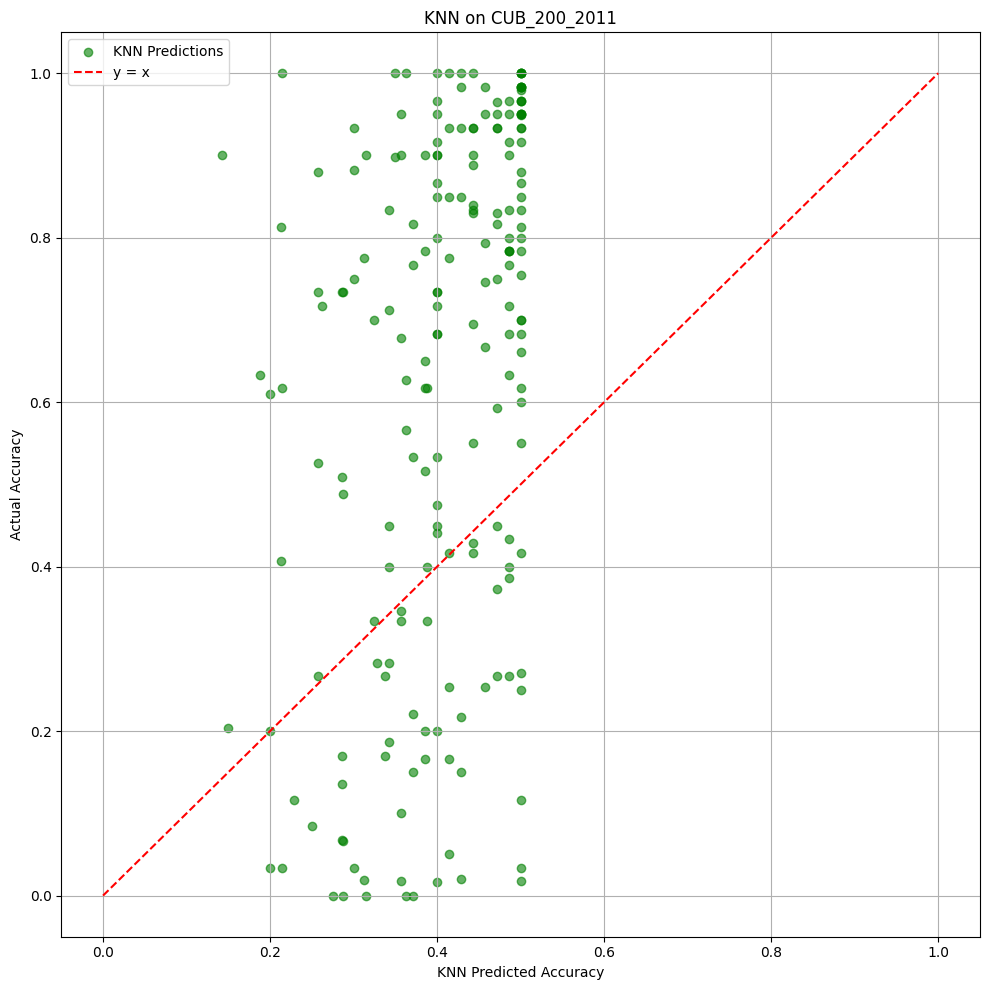


Spearman Correlation Coefficient (KNN Avg Probabilities vs Actual): 0.4021
P-value: 3.6026e-09
Average Error of KNN Prediction vs Actual Accuracies: 0.3270


In [ ]:
# %%
# =========================
# Plot KNN Average Probabilities vs. Actual Accuracies
# =========================

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

# Filter labels that have both actual accuracies and KNN average probabilities
filtered_labels_knn = [
    label for label in n_classes
    if real_per_class_accuracy.get(label) is not None and knn_per_class_probabilities.get(label) is not None
]

# Extract accuracies and average probabilities
actual_accuracies_knn = [real_per_class_accuracy[label] for label in filtered_labels_knn]
knn_avg_probabilities = [knn_per_class_probabilities[label] for label in filtered_labels_knn]

# Plot KNN average probabilities vs actual accuracies
plt.figure(figsize=(10, 10))
plt.scatter(knn_avg_probabilities, actual_accuracies_knn, color='green', alpha=0.6, label='KNN Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='y = x')  # Reference line

# Optional: Annotate each point with the class label
# for i, label in enumerate(filtered_labels_knn):
#     plt.text(knn_avg_probabilities[i], actual_accuracies_knn[i], label, fontsize=9, ha='right', va='bottom')

plt.xlabel('KNN Predicted Accuracy')
plt.ylabel('Actual Accuracy')
plt.title(f'KNN on {DATASET_NAME}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute Spearman correlation
spearman_corr_knn, p_value_knn = spearmanr(knn_avg_probabilities, actual_accuracies_knn)
print(f"\nSpearman Correlation Coefficient (KNN Avg Probabilities vs Actual): {spearman_corr_knn:.4f}")
print(f"P-value: {p_value_knn:.4e}")

# Compute absolute differences between KNN predicted accuracies and actual accuracies
absolute_errors = np.abs(np.array(knn_avg_probabilities) - np.array(actual_accuracies_knn))

# Compute the average error
average_error = np.mean(absolute_errors)

print(f"Average Error of KNN Prediction vs Actual Accuracies: {average_error:.4f}")


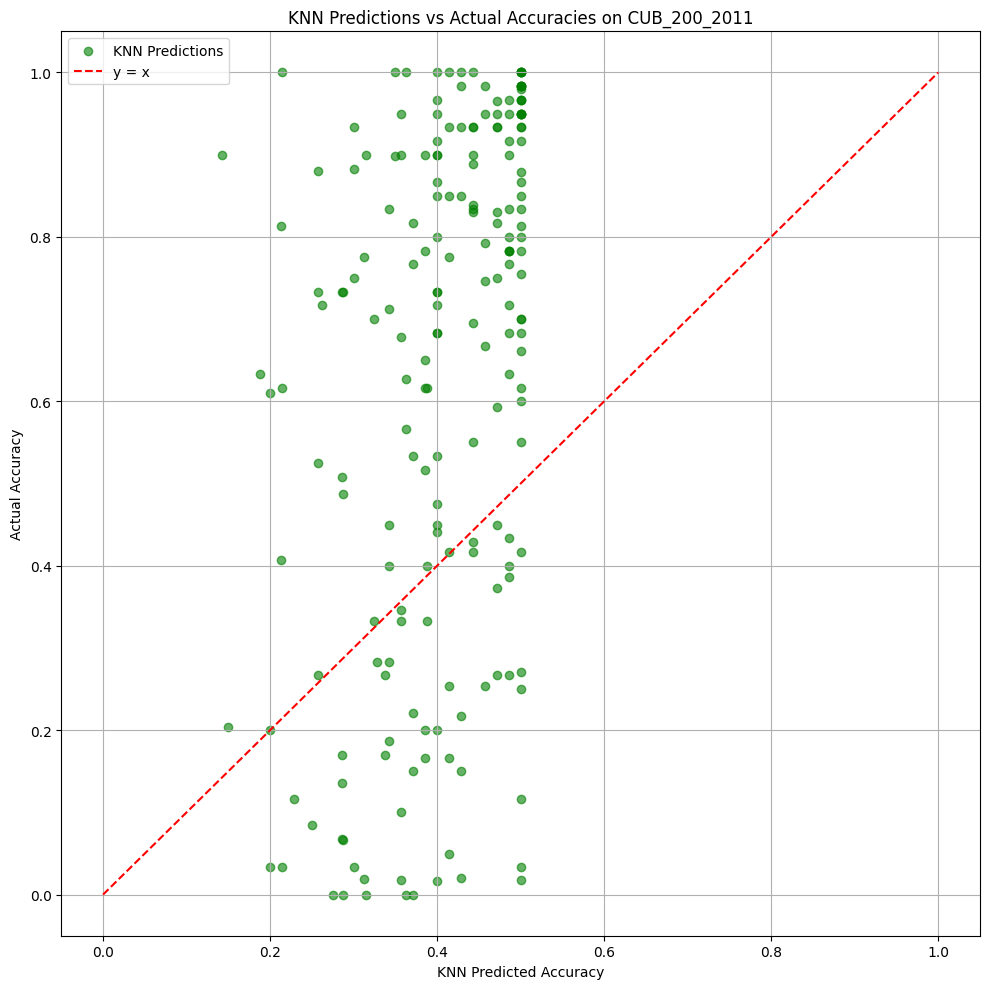


Spearman Correlation Coefficient (KNN Avg Probabilities vs Actual): 0.4021
P-value: 3.6026e-09
Average Error of KNN Prediction vs Actual Accuracies: 0.3270


In [ ]:
# %%
# =========================
# Plot KNN Average Probabilities vs. Actual Accuracies
# =========================

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

# Filter labels that have both actual accuracies and KNN average probabilities
filtered_labels_knn = [
    label for label in n_classes
    if real_per_class_accuracy.get(label) is not None and knn_per_class_probabilities.get(label) is not None
]

# Extract accuracies and average probabilities
actual_accuracies_knn = [real_per_class_accuracy[label] for label in filtered_labels_knn]
knn_avg_probabilities = [knn_per_class_probabilities[label] for label in filtered_labels_knn]

# Plot KNN average probabilities vs actual accuracies
plt.figure(figsize=(10, 10))
plt.scatter(knn_avg_probabilities, actual_accuracies_knn, color='green', alpha=0.6, label='KNN Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='y = x')  # Reference line

# Define thresholds for high KNN predicted accuracy and low actual accuracy
HIGH_KNN_THRESHOLD = 0.7  # Adjust as needed
LOW_ACTUAL_THRESHOLD = 0.2  # Adjust as needed

# Identify classes that meet both conditions
problematic_classes = [
    label for label in filtered_labels_knn
    if knn_per_class_probabilities[label] >= HIGH_KNN_THRESHOLD and real_per_class_accuracy[label] <= LOW_ACTUAL_THRESHOLD
]

# Annotate these classes on the plot
for label in problematic_classes:
    knn_prob = knn_per_class_probabilities[label]
    actual_acc = real_per_class_accuracy[label]
    plt.text(knn_prob, actual_acc, label, fontsize=9, ha='right', va='bottom',
             color='red', weight='bold')

plt.xlabel('KNN Predicted Accuracy')
plt.ylabel('Actual Accuracy')
plt.title(f'KNN Predictions vs Actual Accuracies on {DATASET_NAME}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute Spearman correlation
spearman_corr_knn, p_value_knn = spearmanr(knn_avg_probabilities, actual_accuracies_knn)
print(f"\nSpearman Correlation Coefficient (KNN Avg Probabilities vs Actual): {spearman_corr_knn:.4f}")
print(f"P-value: {p_value_knn:.4e}")

# Compute absolute differences between KNN predicted accuracies and actual accuracies
absolute_errors = np.abs(np.array(knn_avg_probabilities) - np.array(actual_accuracies_knn))

# Compute the average error
average_error = np.mean(absolute_errors)

print(f"Average Error of KNN Prediction vs Actual Accuracies: {average_error:.4f}")

In [ ]:
# cub corr. 0.5212/ 0.5530 / 0.5966 new prompt 32 /
# stanford dogs corr. 0.42 / 0.4391 / 0.4433 new prompt 32 /
# flower corr. 0.3000 / 0.3199 / 0.4513 / 0.3219 idk why
# 'NWPU-RESISC45' 0.4321 / 0.0679 idk why


Generating t-SNE visualization...
Visualizing the specified classes: ['Green Jay', 'Bobolink', 'White crowned Sparrow', 'Bronzed Cowbird', 'White breasted Kingfisher', 'Clark Nutcracker', 'American Redstart', 'Chuck will Widow', 'Sooty Albatross', 'Indigo Bunting']
Performing t-SNE dimensionality reduction...


C:\Users\Wuy19\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Wuy19\AppData\Local\Temp\ipykernel_74144\1995636519.py:84: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


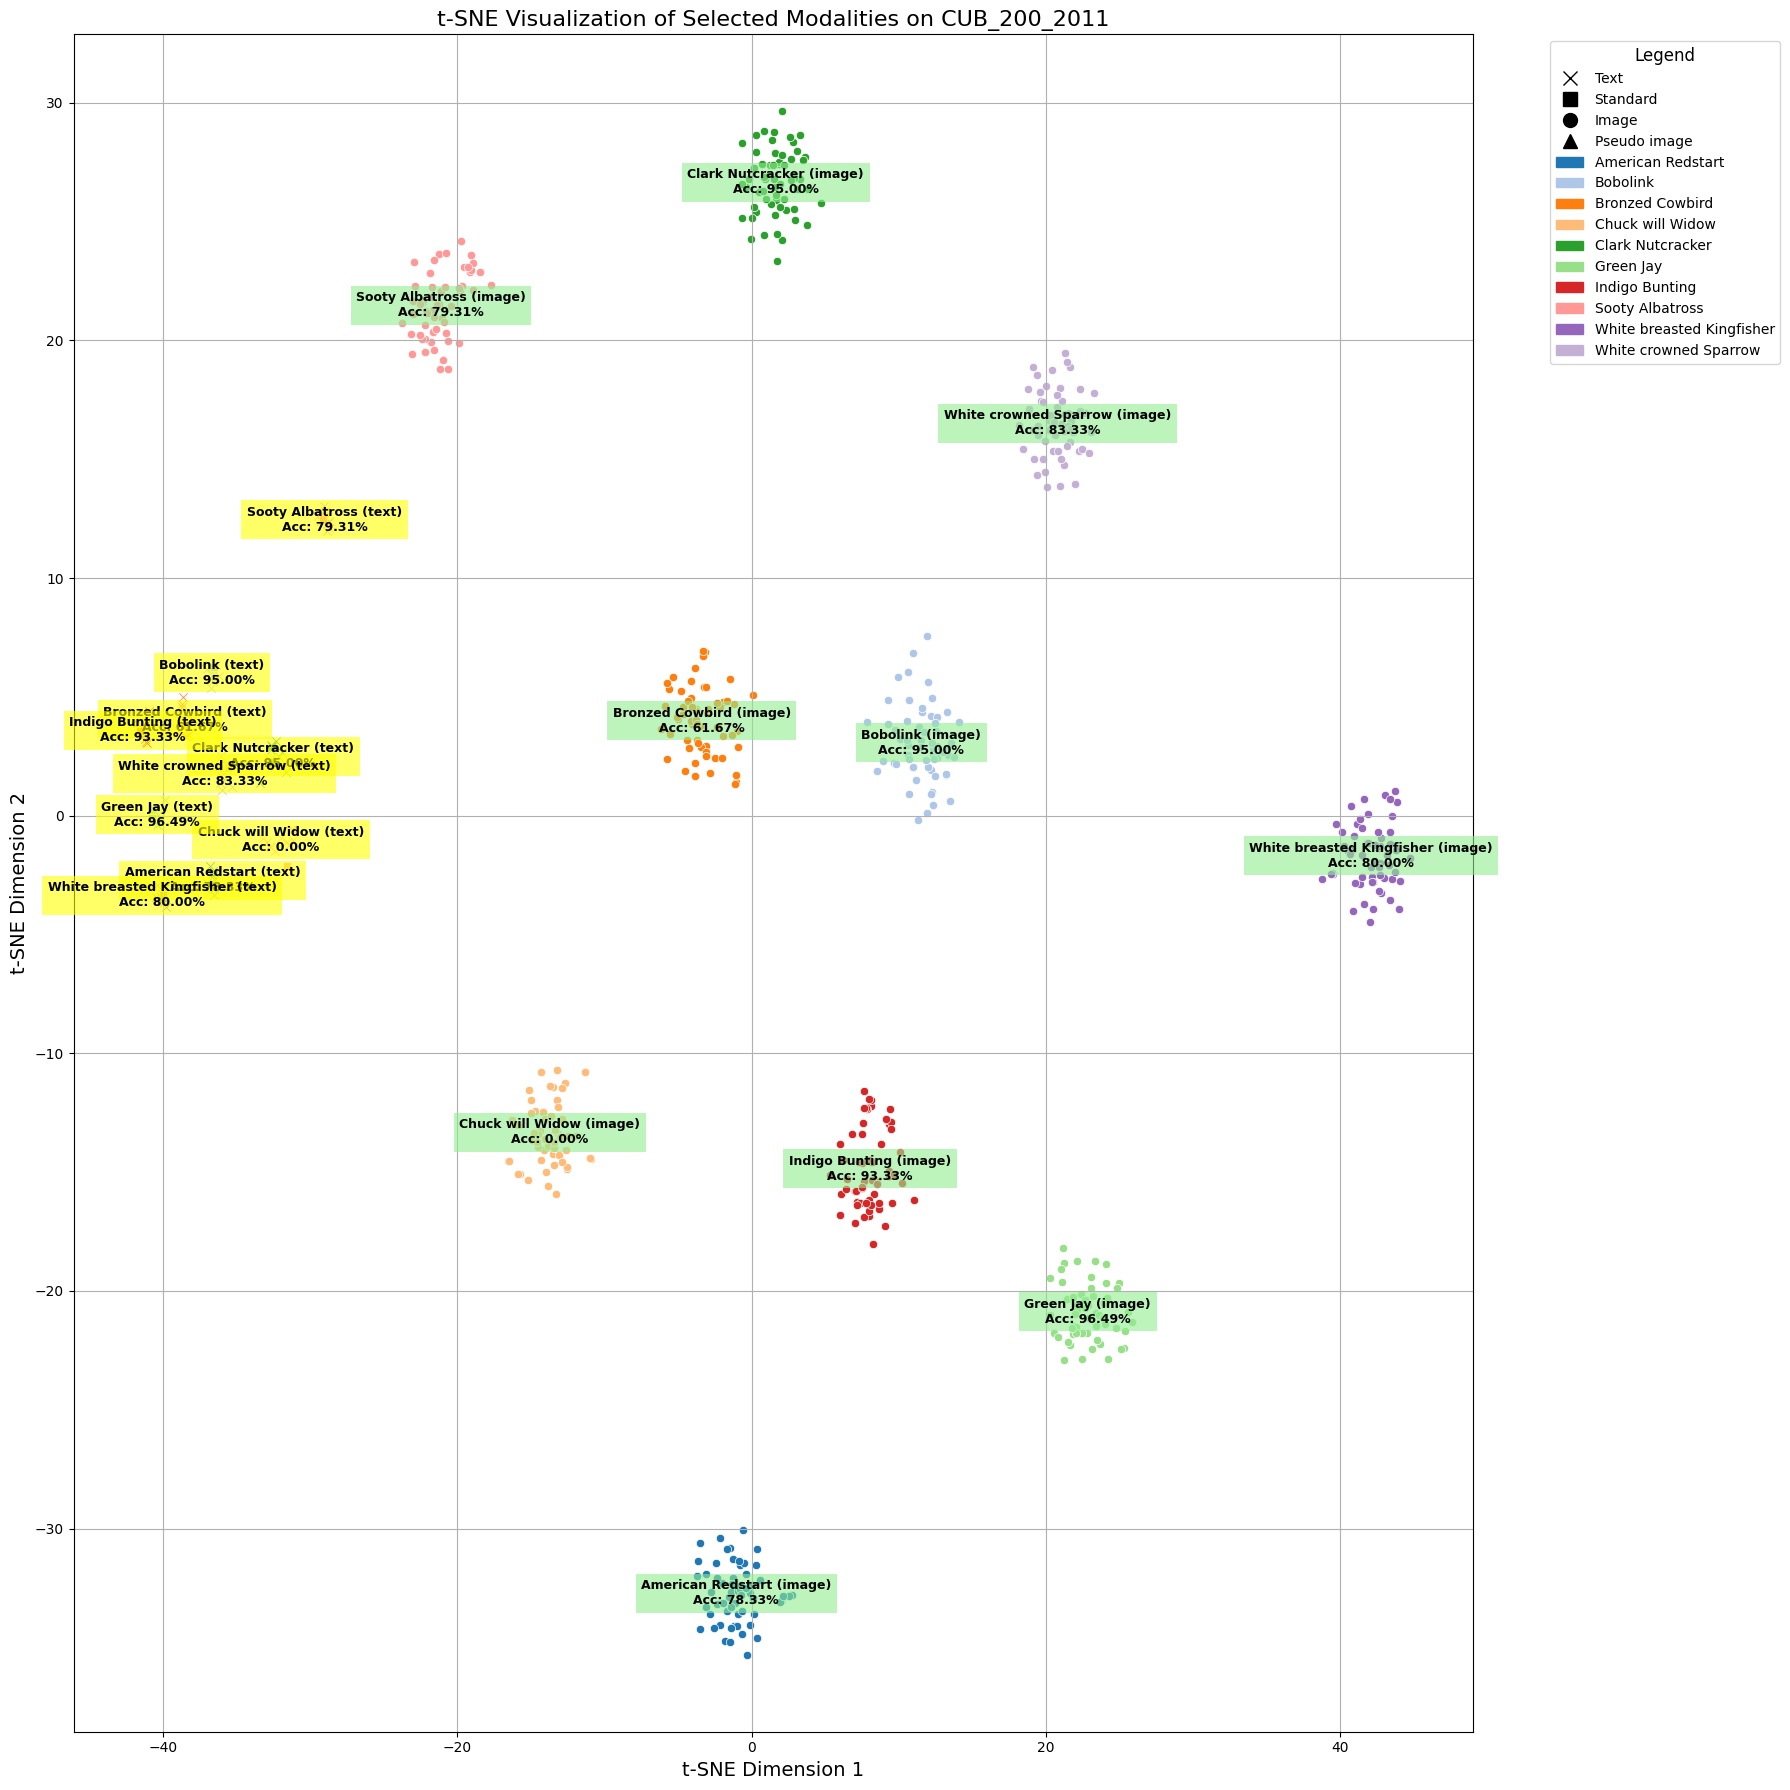

In [ ]:
def plot_tsne(combined_embeddings, combined_labels, combined_modalities, 
             per_class_accuracy, n_classes, top_k=12, selected_modalities=['text', 'standard', 'image', 'pseudo_image'],
             selected_class_names=None):
    """
    Perform t-SNE visualization on selected modalities and classes.

    Args:
        combined_embeddings (np.ndarray): Combined embeddings of all modalities.
        combined_labels (List[str]): Labels corresponding to each embedding.
        combined_modalities (List[str]): Modalities corresponding to each embedding.
        per_class_accuracy (dict): Per-class accuracy for annotation.
        n_classes (List[str]): List of all class names.
        top_k (int): Number of top classes to visualize if selected_class_names is not provided.
        selected_modalities (List[str]): Modalities to include in the visualization.
        selected_class_names (List[str], optional): Specific class names to visualize. 
                                                   If provided, overrides top_k selection.

    Raises:
        ValueError: If any of the selected_class_names are not present in n_classes.
    """
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D
    from adjustText import adjust_text  # Import adjustText for annotation adjustment

    # Determine the classes to visualize
    if selected_class_names is not None:
        # Validate provided class names
        invalid_classes = [cls for cls in selected_class_names if cls not in n_classes]
        if invalid_classes:
            raise ValueError(f"The following classes are not present in the dataset: {invalid_classes}")
        top_k_classes = selected_class_names
        print(f"Visualizing the specified classes: {top_k_classes}")
    else:
        # Select the first k classes
        top_k_classes = n_classes[:top_k]
        print(f"Visualizing the first {top_k} classes: {top_k_classes}")

    # Create a mask using NumPy for proper boolean indexing
    mask = np.array([
        (mod in selected_modalities) and (label in top_k_classes)
        for label, mod in zip(combined_labels, combined_modalities)
    ])

    # Apply the mask to filter embeddings, labels, and modalities
    filtered_embeddings = combined_embeddings[mask]
    filtered_labels = np.array(combined_labels)[mask]
    filtered_modalities = np.array(combined_modalities)[mask]

    if filtered_embeddings.size == 0:
        print("No data points match the selected modalities and classes.")
        return

    # Perform t-SNE
    print("Performing t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER)
    tsne_results = tsne.fit_transform(filtered_embeddings)

    # Assign colors to classes
    unique_classes = sorted(set(filtered_labels))
    cmap = plt.get_cmap('tab20')  # Up to 20 distinct colors
    colors = cmap.colors
    class_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_classes)}

    # Define markers for modalities
    markers = {
        'text': 'x',
        'standard': 's',
        'image': 'o',
        'pseudo_image': '^'
    }

    plt.figure(figsize=(18, 18))

    # Group data by class and modality for efficient plotting
    for class_name in unique_classes:
        for modality in selected_modalities:
            # Create a boolean mask for the current class and modality
            group_mask = (filtered_labels == class_name) & (filtered_modalities == modality)
            group_embeddings = tsne_results[group_mask]

            if group_embeddings.size == 0:
                continue  # Skip if no data points in this group

            plt.scatter(
                group_embeddings[:, 0],
                group_embeddings[:, 1],
                color=class_to_color[class_name],
                marker=markers.get(modality, 'o'),  # Default to 'o' if modality not found
                # alpha=0.7,
                edgecolors='w',
                linewidth=0.5,
                label=f"{class_name} - {modality}"  # Unique label for legend
            )

    # Create legend entries for modalities
    modality_handles = [
        Line2D([], [], color='black', marker=markers[mod], linestyle='None',
               markersize=10, label=mod.capitalize().replace('_', ' '))
        for mod in selected_modalities
    ]

    # Create legend entries for classes (colors)
    class_patches = [
        mpatches.Patch(color=class_to_color[label], label=label) 
        for label in unique_classes
    ]

    # Combine modality handles and class patches
    all_handles = modality_handles + class_patches

    # Place the legend outside the plot
    plt.legend(handles=all_handles, bbox_to_anchor=(1.05, 1), loc='upper left', 
               title='Legend', fontsize=10, title_fontsize=12)

    # Initialize a list to hold all text annotations
    texts = []

    # Annotate each class within each modality
    for class_name in unique_classes:
        for modality in selected_modalities:
            # skip some modalities
            if modality == 'standard' or modality == 'pseudo_image':
                continue
            # Create a mask for the current class and modality
            annotation_mask = (filtered_labels == class_name) & (filtered_modalities == modality)
            group_embeddings = tsne_results[annotation_mask]

            if group_embeddings.size == 0:
                continue  # Skip if no data points in this group

            # Compute mean position for annotation
            mean_x = group_embeddings[:, 0].mean()
            mean_y = group_embeddings[:, 1].mean()

            acc = per_class_accuracy.get(class_name, 0)

            # Define bbox properties based on modality
            if modality == 'text':
                bbox_props = {'facecolor': 'yellow', 'alpha': 0.6, 'edgecolor': 'none'}
            elif modality == 'standard':
                bbox_props = {'facecolor': 'cyan', 'alpha': 0.6, 'edgecolor': 'none'}
            elif modality == 'image':
                bbox_props = {'facecolor': 'lightgreen', 'alpha': 0.6, 'edgecolor': 'none'}
            elif modality == 'pseudo_image':
                bbox_props = {'facecolor': 'lightcoral', 'alpha': 0.6, 'edgecolor': 'none'}
            else:
                bbox_props = {'facecolor': 'white', 'alpha': 0.6, 'edgecolor': 'none'}

            # Create the text annotation
            text = plt.text(
                mean_x, mean_y, f"{class_name} ({modality})\nAcc: {acc:.2%}",
                fontsize=9, weight='bold',
                ha='center', va='center', color='black',
                bbox=bbox_props
            )
            texts.append(text)

    # # Adjust text annotations to prevent overlapping
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    plt.title(f't-SNE Visualization of Selected Modalities on {DATASET_NAME}', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=14)
    plt.ylabel('t-SNE Dimension 2', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =========================
# t-SNE Visualization with Modality and Class Control
# =========================
print("Generating t-SNE visualization...")
# Define the modalities you want to include in the visualization
selected_modalities = ['text', 'standard', 'image', 'pseudo_image']  # Modify as needed

# Call the t-SNE plotting function with class control
# random sample some classes
import random
random_classes = random.sample(n_classes, 10)
plot_tsne(
    combined_embeddings=combined_embeddings,
    combined_labels=combined_labels,
    combined_modalities=combined_modalities,
    per_class_accuracy=real_per_class_accuracy,
    n_classes=n_classes,
    top_k=TOP_K_CLASSES,
    selected_modalities=selected_modalities,
    selected_class_names=problematic_classes+random_classes,
)


In [ ]:
# %%
# =========================
# Import Necessary Libraries
# =========================
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import json

# Define the compute_prediction_stats function
def compute_prediction_stats(image_embeddings, image_labels, standard_embeddings, standard_labels):
    """
    Computes prediction statistics for each class.

    Args:
        image_embeddings (np.ndarray): Array of image embeddings (N x D).
        image_labels (List[str]): List of actual class labels for each image.
        standard_embeddings (np.ndarray): Array of standard text embeddings (C x D).
        standard_labels (List[str]): List of class labels corresponding to standard_embeddings.

    Returns:
        dict: Nested dictionary where prediction_stats[actual_class][predicted_class] = count.
    """
    # Ensure that image_embeddings and standard_embeddings are NumPy arrays
    image_embeddings = np.array(image_embeddings)
    standard_embeddings = np.array(standard_embeddings)

    # Normalize image embeddings and standard text embeddings
    image_norm = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)
    text_norm = standard_embeddings / np.linalg.norm(standard_embeddings, axis=1, keepdims=True)

    # Compute cosine similarity between each image and all standard texts
    # This results in a (N x C) similarity matrix
    similarity = np.dot(image_norm, text_norm.T)

    # Get the index of the highest similarity score for each image
    predicted_indices = np.argmax(similarity, axis=1)

    # Map indices to class labels
    predicted_labels = [standard_labels[idx] for idx in predicted_indices]

    # Initialize a nested dictionary to store counts
    prediction_stats = defaultdict(lambda: defaultdict(int))

    # Iterate through actual and predicted labels to count occurrences
    for actual, predicted in tqdm(zip(image_labels, predicted_labels), total=len(image_labels), desc="Computing Prediction Statistics"):
        prediction_stats[actual][predicted] += 1

    # Convert defaultdicts to regular dicts for easier handling
    prediction_stats = {actual: dict(predictions) for actual, predictions in prediction_stats.items()}

    return prediction_stats

# Define the query_prediction_stats function
def query_prediction_stats(prediction_stats, actual_class):
    """
    Queries the prediction statistics for a given actual class.

    Args:
        prediction_stats (dict): Nested dictionary from compute_prediction_stats.
        actual_class (str): The actual class name to query.

    Returns:
        List[Tuple[str, int]]: List of (predicted_class, count) sorted descending by count.
    """
    if actual_class not in prediction_stats:
        print(f"Class '{actual_class}' not found in prediction statistics.")
        return []

    predicted_counts = prediction_stats[actual_class]

    # Sort the predicted classes by count in descending order
    sorted_predicted = sorted(predicted_counts.items(), key=lambda x: x[1], reverse=True)

    return sorted_predicted

# Define a helper function to display sorted predictions
def display_sorted_predictions(prediction_stats, actual_class):
    """
    Displays sorted prediction counts for a given actual class.

    Args:
        prediction_stats (dict): Nested dictionary of prediction statistics.
        actual_class (str): The actual class name to query.
    """
    sorted_predictions = query_prediction_stats(prediction_stats, actual_class)
    
    if not sorted_predictions:
        return
    
    print(f"\nPrediction Statistics for Actual Class '{actual_class}':")
    print(f"{'Predicted Class':<30} {'Count':<10}")
    print("-" * 40)
    for pred_class, count in sorted_predictions:
        print(f"{pred_class:<30} {count:<10}")
    # return pred_classes
    return [pred_class for pred_class, count in sorted_predictions]

# %%
# =========================
# Compute Prediction Statistics
# =========================

prediction_stats = compute_prediction_stats(
    image_embeddings=image_embeddings,      # Your existing image embeddings
    image_labels=image_labels,              # Your existing image labels
    standard_embeddings=standard_embeddings,  # Your existing standard text embeddings
    standard_labels=standard_labels          # Your existing standard labels
)

# %%
# =========================
# Query and Display Prediction Statistics for Specific Classes
# =========================

# Example classes to query
classes_to_query = ['Bank Swallow']  # Replace with your desired class names

preded_classes = []
for i in range(len(classes_to_query)):
    preded_classes += display_sorted_predictions(prediction_stats, classes_to_query[i])[:10]

# %%
# =========================
# Generate and Save Prediction Statistics for All Classes
# =========================

# Initialize a dictionary to store sorted prediction statistics for all classes
sorted_prediction_stats = {}

for class_name in tqdm(n_classes, desc="Generating Sorted Prediction Statistics for All Classes"):
    sorted_predictions = query_prediction_stats(prediction_stats, class_name)
    sorted_prediction_stats[class_name] = sorted_predictions

# Optionally, save the statistics to a JSON file for future reference
with open('prediction_stats.json', 'w') as f:
    json.dump(sorted_prediction_stats, f, indent=4)

print("\nPrediction statistics for all classes have been saved to 'prediction_stats.json'.")


Computing Prediction Statistics: 100%|██████████| 11788/11788 [00:00<00:00, 1681201.52it/s]



Prediction Statistics for Actual Class 'Bank Swallow':
Predicted Class                Count     
----------------------------------------
Bank Swallow                   30        
Western Wood Pewee             7         
Least Flycatcher               6         
Cliff Swallow                  6         
Gray Kingbird                  5         
Tree Swallow                   1         
Barn Swallow                   1         
Philadelphia Vireo             1         
Seaside Sparrow                1         
Black Tern                     1         


Generating Sorted Prediction Statistics for All Classes: 100%|██████████| 200/200 [00:00<00:00, 199776.33it/s]


Prediction statistics for all classes have been saved to 'prediction_stats.json'.


C:\Users\Wuy19\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualizing the specified classes: ['Bank Swallow', 'Western Wood Pewee', 'Least Flycatcher', 'Cliff Swallow', 'Gray Kingbird', 'Tree Swallow', 'Barn Swallow', 'Philadelphia Vireo', 'Seaside Sparrow', 'Black Tern', 'Bank Swallow']
Performing t-SNE dimensionality reduction...


C:\Users\Wuy19\AppData\Local\Temp\ipykernel_74144\1995636519.py:84: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


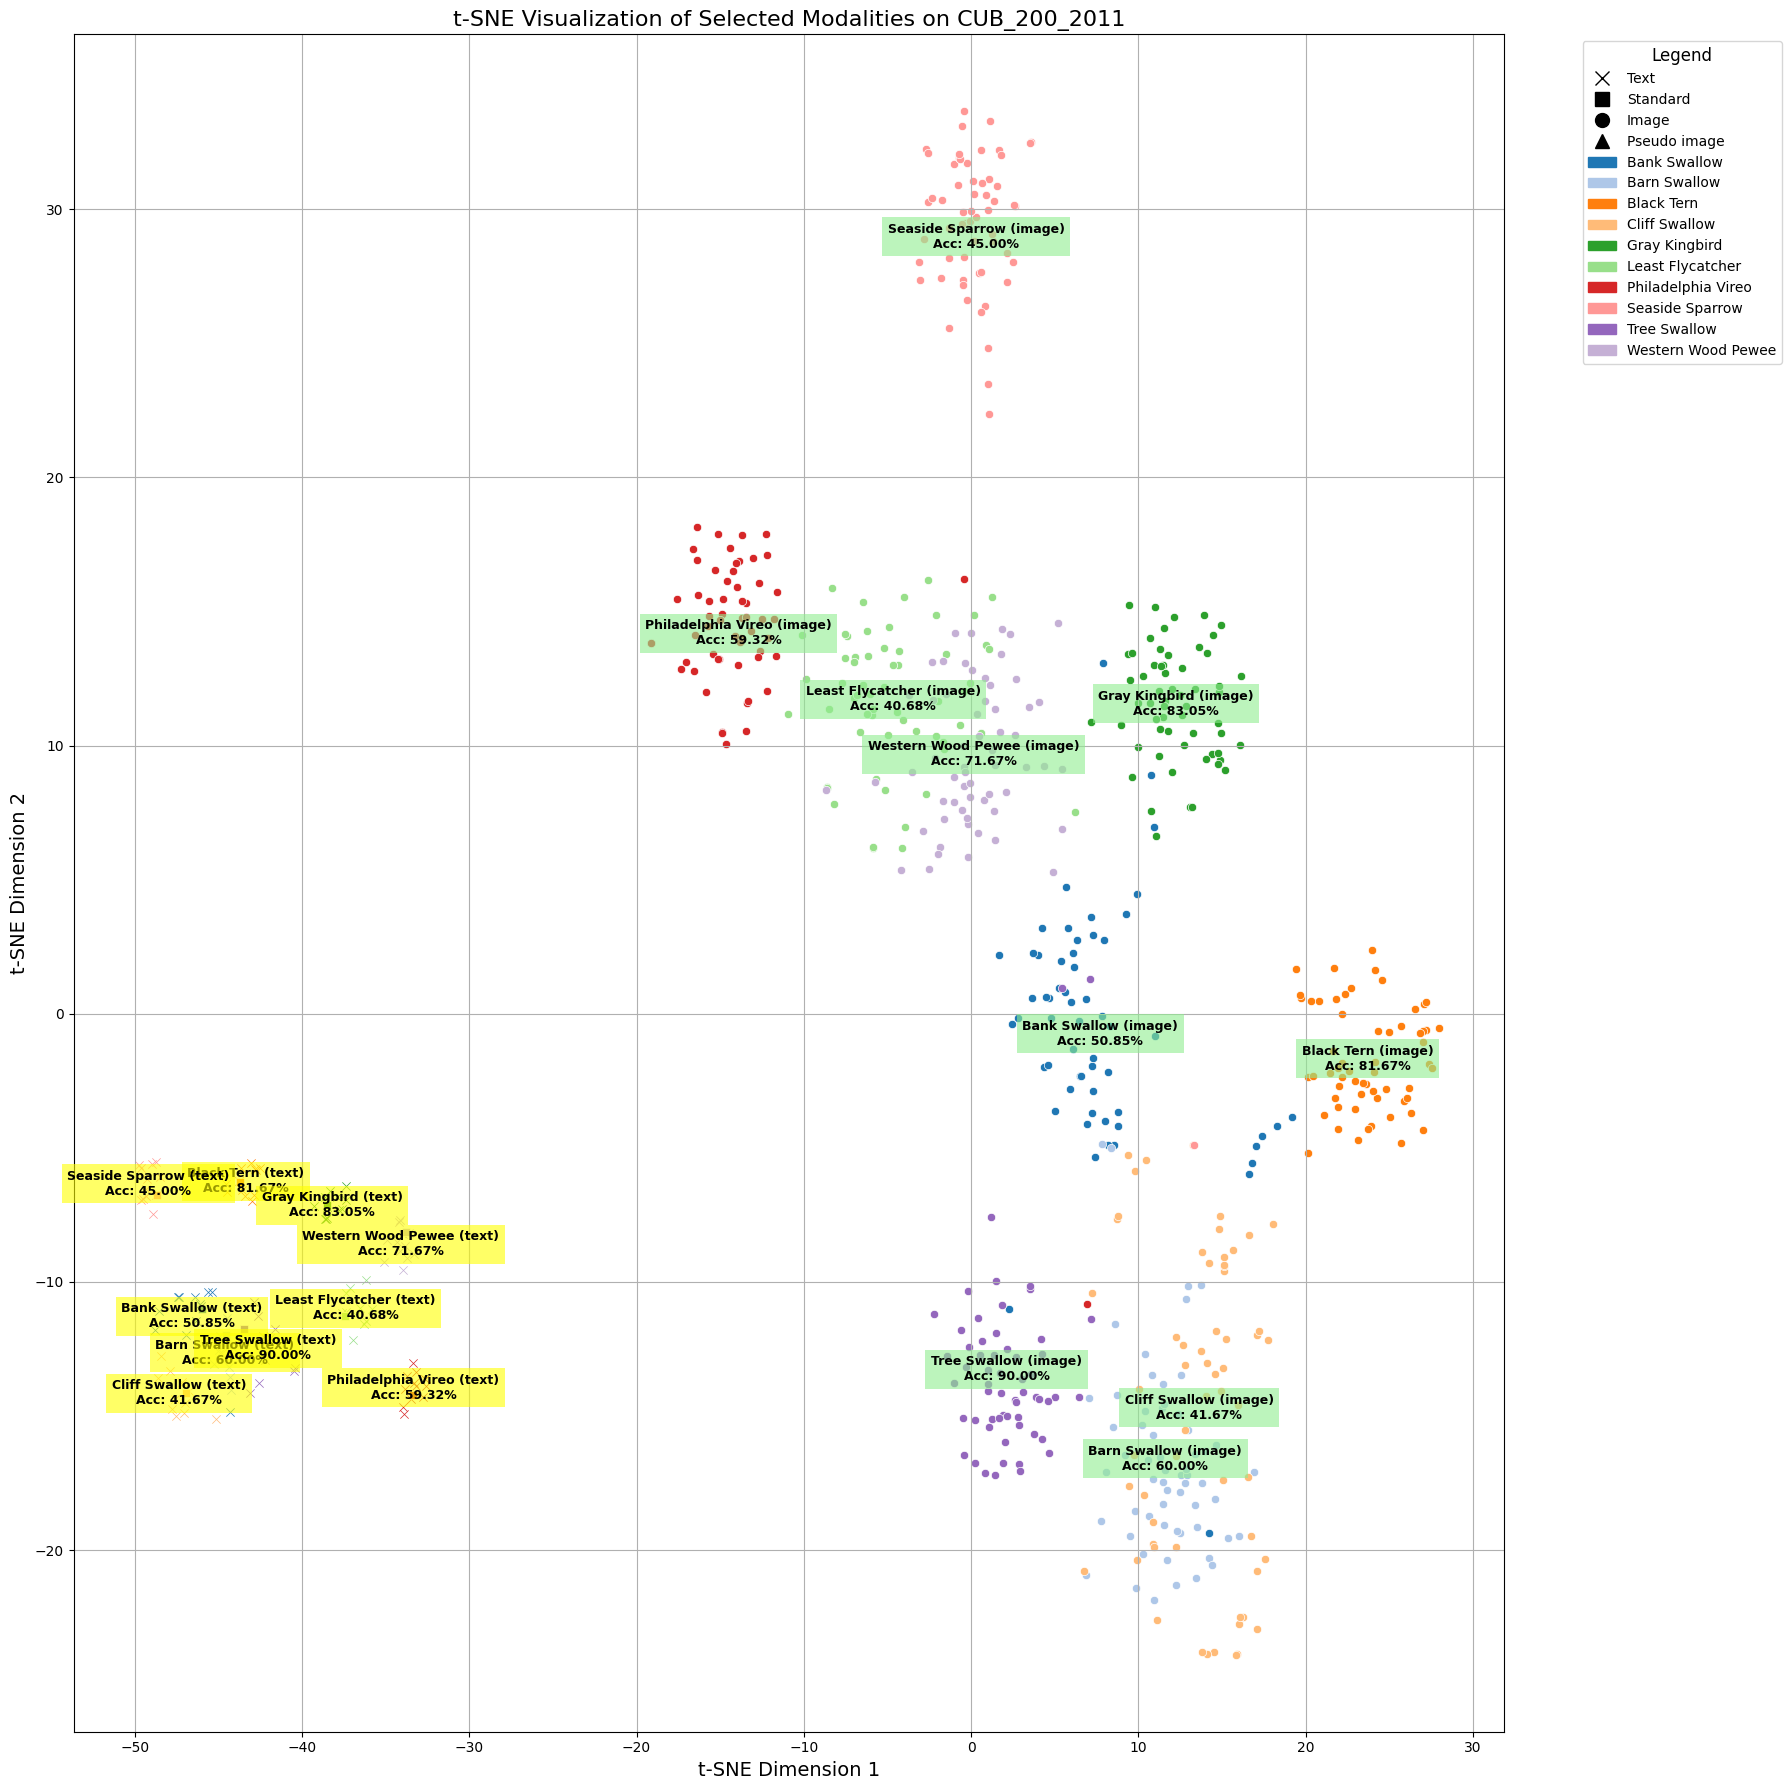

In [ ]:
plot_tsne(
    combined_embeddings=combined_embeddings,
    combined_labels=combined_labels,
    combined_modalities=combined_modalities,
    per_class_accuracy=real_per_class_accuracy,
    n_classes=n_classes,
    top_k=TOP_K_CLASSES,
    selected_modalities=selected_modalities,
    selected_class_names=preded_classes + classes_to_query,
)